In [9]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import imageio

# =============================================================================
# Module: motion_estimation.py
# =============================================================================
class MotionEstimation(tf.Module):
    def __init__(self, batch_size, height, width):
        super().__init__()
        self.batch_size = batch_size
        self.height = height
        self.width = width

    def _build_pyramid(self, image):
        level3 = tf.keras.layers.AveragePooling2D(2, 2, 'same')(image)
        level2 = tf.keras.layers.AveragePooling2D(2, 2, 'same')(level3)
        level1 = tf.keras.layers.AveragePooling2D(2, 2, 'same')(level2)
        level0 = tf.keras.layers.AveragePooling2D(2, 2, 'same')(level1)
        return [level0, level1, level2, level3, image]

    def _convnet(self, im1_warp, im2, flow, layer):
        x = tf.concat([im1_warp, im2, flow], -1)
        x = tf.keras.layers.Conv2D(32, 7, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(64, 7, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(32, 7, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(16, 7, padding='same', activation='relu')(x)
        return tf.keras.layers.Conv2D(2, 7, padding='same')(x)

    def _loss(self, flow_coarse, im1, im2, layer):
        flow = tf.image.resize(flow_coarse, [tf.shape(im1)[1], tf.shape(im1)[2]])
        im1_warped = tfa.image.dense_image_warp(im1, flow)
        res = self._convnet(im1_warped, im2, flow, layer)
        flow_fine = res + flow
        im1_warped_fine = tfa.image.dense_image_warp(im1, flow_fine)
        return tf.reduce_mean(tf.square(im1_warped_fine - im2)), flow_fine

    def estimate_flow(self, im1, im2):
        pyramid_im1 = self._build_pyramid(im1)
        pyramid_im2 = self._build_pyramid(im2)
        flow = tf.zeros([self.batch_size, self.height//16, self.width//16, 2])
        losses = []
        for level in range(5):
            loss, flow = self._loss(flow, pyramid_im1[level], pyramid_im2[level], level)
            losses.append(loss)
        return flow, losses

# =============================================================================
# Module: entropy_model.py
# =============================================================================
class EntropyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # Hyperprior networks for entropy estimation
        self.hyper_mean = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 3, 1, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 1, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 1, 'same'),
        ])

        self.hyper_scale = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 3, 1, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 1, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 1, 'same'),
        ])

    def call(self, quantized, quantization_step):
        mean = self.hyper_mean(quantized)
        scale = tf.nn.softplus(self.hyper_scale(quantized)) + 1e-6

        # Rate estimation using probability computed from the hyperprior
        upper = quantized + quantization_step / 2
        lower = quantized - quantization_step / 2
        cdf_upper = 0.5 * (1 + tf.math.erf((upper - mean) / (scale * tf.sqrt(2.0))))
        cdf_lower = 0.5 * (1 + tf.math.erf((lower - mean) / (scale * tf.sqrt(2.0))))
        prob = cdf_upper - cdf_lower
        entropy = -tf.math.log(prob + 1e-10) / tf.math.log(2.0)
        return entropy

# =============================================================================
# Module: autoencoder.py
# =============================================================================
class MotionAutoencoder(tf.keras.Model):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width

        # Enhanced Encoder with Instance Normalization
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
        ])

        # Instantiate the EntropyModel
        self.entropy_model = EntropyModel()

        # Enhanced Decoder with Instance Normalization
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(128, 3, 2, 'same'),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(2, 3, 1, 'same')
        ])

        # Smaller quantization step to start
        self.quantization_step = tf.Variable(0.01, trainable=True)

    def quantize(self, x):
        # Adds some rounding noise... because perfection is overrated.
        return x + tf.stop_gradient(tf.round(x / self.quantization_step) * self.quantization_step - x)

    def call(self, mv, training=False):
        # Normalize input motion vectors to [-1, 1]
        mv_magnitude = tf.norm(mv, axis=-1, keepdims=True)
        mv_normalized = mv / (tf.reduce_max(mv_magnitude) + 1e-8)

        # Encode and quantize
        compressed = self.encoder(mv_normalized)
        quantized = self.quantize(compressed)

        # Compute entropy using our separate entropy model
        entropy = self.entropy_model(quantized, self.quantization_step)

        # Decode and denormalize
        decoded = self.decoder(quantized)
        decoded = decoded * tf.reduce_max(mv_magnitude)  # scale back to original range

        return decoded, entropy

# =============================================================================
# Module: training.py
# =============================================================================
def train_autoencoder(autoencoder, flow, epochs=200, beta=0.01):
    optimizer = tf.keras.optimizers.Adam(0.001)
    flow = tf.convert_to_tensor(flow, dtype=tf.float32)

    # Calculate magnitude for normalization
    flow_magnitude = tf.norm(flow, axis=-1)
    max_magnitude = tf.reduce_max(flow_magnitude)

    losses, rates, dists, q_steps = [], [], [], []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            decoded, entropy = autoencoder(flow, training=True)

            # Magnitude-based distortion
            orig_magnitude = tf.norm(flow, axis=-1)
            recon_magnitude = tf.norm(decoded, axis=-1)
            distortion = tf.reduce_mean(tf.abs(orig_magnitude - recon_magnitude))

            rate = tf.reduce_mean(entropy)
            loss = distortion + beta * rate

        grads = tape.gradient(loss, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(grads, autoencoder.trainable_variables))

        losses.append(loss.numpy())
        rates.append(rate.numpy())
        dists.append(distortion.numpy())
        q_steps.append(autoencoder.quantization_step.numpy())

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}:")
            print(f"  Loss: {loss:.4f}")
            print(f"  Distortion: {distortion:.4f}")
            print(f"  Rate: {rate:.4f}")
            print(f"  Quant Step: {autoencoder.quantization_step.numpy():.4f}")
            print(f"  Decoded Range: [{tf.reduce_min(decoded):.4f}, {tf.reduce_max(decoded):.4f}]")
            print(f"  Flow Range: [{tf.reduce_min(flow):.4f}, {tf.reduce_max(flow):.4f}]")

    return losses, rates, dists, q_steps

# =============================================================================
# Module: visualization.py
# =============================================================================
def visualize_results(original, reconstructed, entropy, losses, dists, rates, q_steps):
    plt.figure(figsize=(18, 6))

    # Original Flow Magnitude
    plt.subplot(1, 4, 1)
    orig_mag = np.sqrt(original[0, ..., 0]**2 + original[0, ..., 1]**2)
    vmax = np.percentile(orig_mag, 95)
    plt.imshow(orig_mag, cmap='jet', vmin=0, vmax=vmax)
    plt.title("Original Flow Magnitude")
    plt.colorbar()

    # Reconstructed Flow Magnitude
    plt.subplot(1, 4, 2)
    recon_mag = np.sqrt(reconstructed[0, ..., 0]**2 + reconstructed[0, ..., 1]**2)
    plt.imshow(recon_mag, cmap='jet', vmin=0, vmax=vmax)
    plt.title("Reconstructed Flow Magnitude")
    plt.colorbar()

    # Error Map
    plt.subplot(1, 4, 3)
    error = np.abs(orig_mag - recon_mag)
    plt.imshow(error, cmap='hot', vmin=0, vmax=np.percentile(error, 95))
    plt.title("Absolute Error")
    plt.colorbar()

    # Entropy Map (mean over channels)
    plt.subplot(1, 4, 4)
    entropy_map = entropy.numpy().squeeze().mean(-1)
    plt.imshow(entropy_map, cmap='viridis')
    plt.title("Entropy Map")
    plt.colorbar()

    plt.tight_layout()
    plt.savefig('flow_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Training Curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.title("Total Loss")

    plt.subplot(1, 3, 2)
    plt.plot(dists)
    plt.title("Distortion")

    plt.subplot(1, 3, 3)
    plt.plot(rates)
    plt.title("Rate")

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Quantization Step Evolution
    plt.figure()
    plt.plot(q_steps)
    plt.title("Quantization Step Evolution")
    plt.savefig('quantization_step.png', dpi=300, bbox_inches='tight')
    plt.close()

# =============================================================================
# Usage Example (Colab-friendly; no main function)
# =============================================================================
# The following code snippets show how you might use the above modules in Colab.

# 1. Estimate Motion
print("Loading images and estimating motion...")
im1 = imageio.imread(r'C:\Users\anish\OneDrive\Desktop\pfe\research2\week4\data\f001.png') / 255.0
im2 = imageio.imread(r'C:\Users\anish\OneDrive\Desktop\pfe\research2\week4\data\f001.png') / 255.0
im1 = ndimage.zoom(im1, (256/im1.shape[0], 256/im1.shape[1], 1))
im2 = ndimage.zoom(im2, (256/im2.shape[0], 256/im2.shape[1], 1))
im1 = tf.convert_to_tensor(im1[np.newaxis], dtype=tf.float32)
im2 = tf.convert_to_tensor(im2[np.newaxis], dtype=tf.float32)

motion_net = MotionEstimation(1, 256, 256)
flow, _ = motion_net.estimate_flow(im1, im2)

# Save original flow visualization
flow_np = flow.numpy()
flow_mag = np.sqrt(flow_np[0, ..., 0]**2 + flow_np[0, ..., 1]**2)
plt.imsave('original_flow.png', flow_mag, cmap='jet')

# 2. Train Autoencoder
print("\nTraining autoencoder...")
autoencoder = MotionAutoencoder(256, 256)
losses, rates, dists, q_steps = train_autoencoder(autoencoder, flow_np, epochs=200)

# 3. Visualize Results
print("\nVisualizing results...")
decoded, entropy = autoencoder(flow)
visualize_results(flow_np, decoded.numpy(), entropy, losses, dists, rates, q_steps)

print("\nTraining complete. Results saved to:")
print("- flow_comparison.png")
print("- training_curves.png")
print("- quantization_step.png")
print("- original_flow.png")


Loading images and estimating motion...


C:\Users\anish\AppData\Local\Temp\ipykernel_24716\581359768.py:288: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im1 = imageio.imread(r'C:\Users\anish\OneDrive\Desktop\pfe\research2\week4\data\f001.png') / 255.0
C:\Users\anish\AppData\Local\Temp\ipykernel_24716\581359768.py:289: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im2 = imageio.imread(r'C:\Users\anish\OneDrive\Desktop\pfe\research2\week4\data\f001.png') / 255.0



Training autoencoder...
Epoch 1:
  Loss: nan
  Distortion: 0.2193
  Rate: nan
  Quant Step: 0.0110
  Decoded Range: [-1.2577, 0.9942]
  Flow Range: [-0.2025, 0.2385]
Epoch 11:
  Loss: 0.1131
  Distortion: 0.0427
  Rate: 7.0399
  Quant Step: 0.0203
  Decoded Range: [-0.9411, 1.4222]
  Flow Range: [-0.2025, 0.2385]
Epoch 21:
  Loss: nan
  Distortion: 0.0334
  Rate: nan
  Quant Step: 0.0284
  Decoded Range: [-0.6882, 0.4882]
  Flow Range: [-0.2025, 0.2385]
Epoch 31:
  Loss: 0.0868
  Distortion: 0.0285
  Rate: 5.8322
  Quant Step: 0.0363
  Decoded Range: [-0.3906, 0.3819]
  Flow Range: [-0.2025, 0.2385]
Epoch 41:
  Loss: 0.0738
  Distortion: 0.0245
  Rate: 4.9331
  Quant Step: 0.0425
  Decoded Range: [-0.2062, 0.2179]
  Flow Range: [-0.2025, 0.2385]
Epoch 51:
  Loss: 0.0738
  Distortion: 0.0220
  Rate: 5.1867
  Quant Step: 0.0483
  Decoded Range: [-0.1864, 0.1807]
  Flow Range: [-0.2025, 0.2385]
Epoch 61:
  Loss: 0.0653
  Distortion: 0.0203
  Rate: 4.4943
  Quant Step: 0.0534
  Decoded Ra

In [1]:
import tensorflow as tf
print(tf.__version__)


2.13.1


In [10]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 0


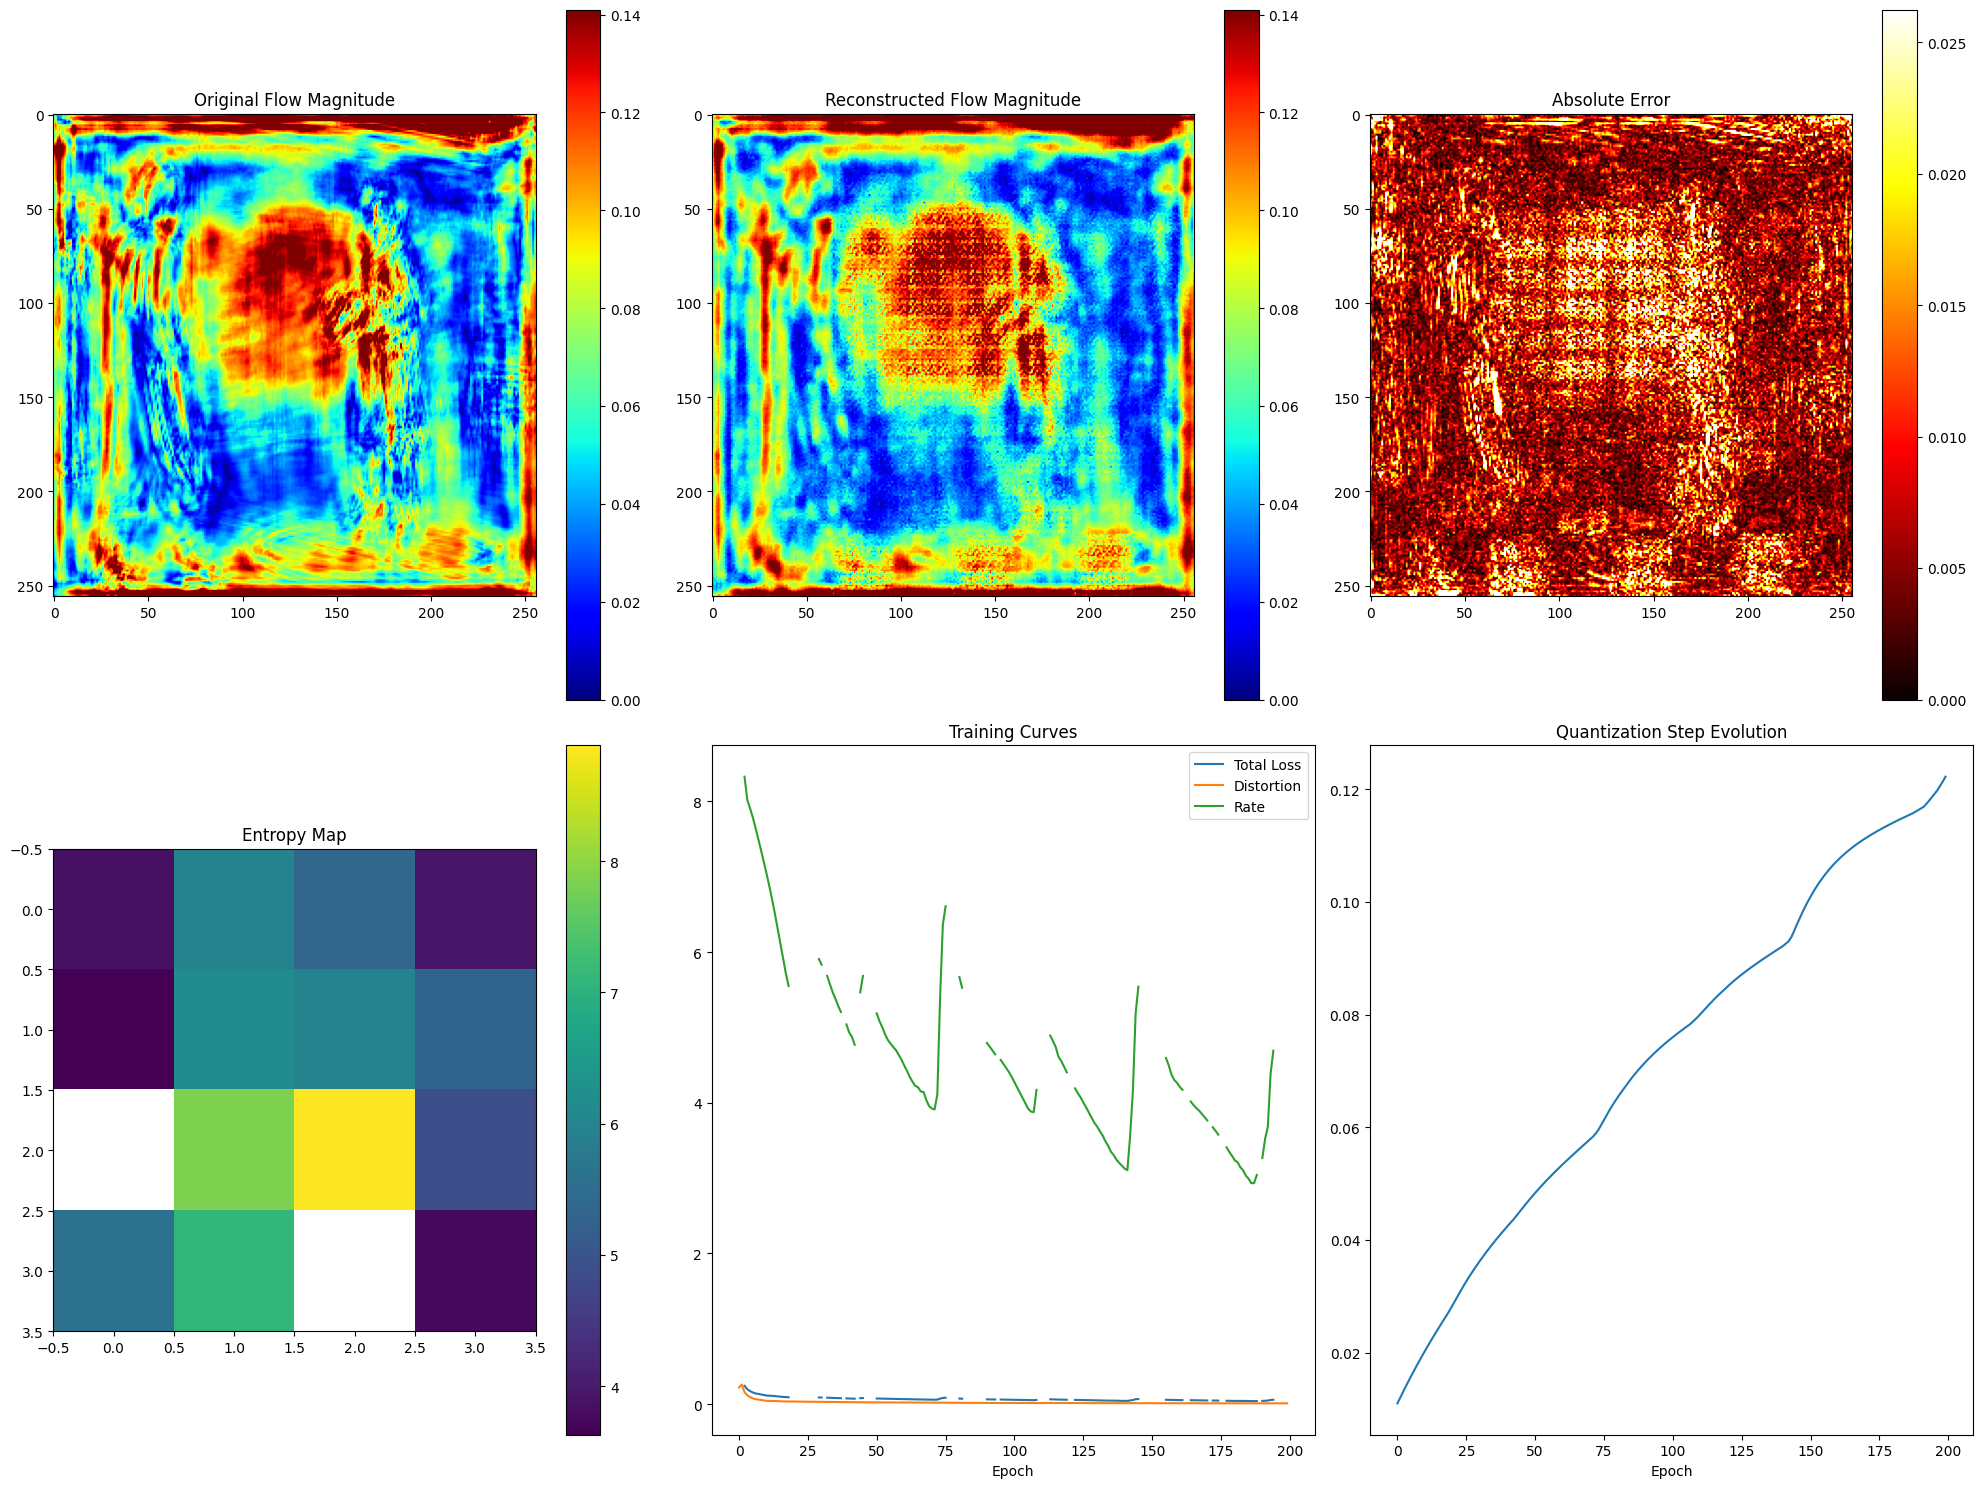

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_in_notebook(original, reconstructed, entropy, losses, dists, rates, q_steps):
    """
    Visualize the results in a Jupyter notebook with interactive plots
    
    Args:
        original: Original flow field (numpy array)
        reconstructed: Reconstructed flow field (numpy array)
        entropy: Entropy map (tensor or numpy array)
        losses: List of loss values during training
        dists: List of distortion values during training
        rates: List of rate values during training
        q_steps: List of quantization steps during training
    """
    plt.figure(figsize=(20, 15))
    
    # Original Flow Magnitude
    plt.subplot(2, 3, 1)
    orig_mag = np.sqrt(original[0, ..., 0]**2 + original[0, ..., 1]**2)
    vmax = np.percentile(orig_mag, 95)
    plt.imshow(orig_mag, cmap='jet', vmin=0, vmax=vmax)
    plt.title("Original Flow Magnitude")
    plt.colorbar()
    
    # Reconstructed Flow Magnitude
    plt.subplot(2, 3, 2)
    recon_mag = np.sqrt(reconstructed[0, ..., 0]**2 + reconstructed[0, ..., 1]**2)
    plt.imshow(recon_mag, cmap='jet', vmin=0, vmax=vmax)
    plt.title("Reconstructed Flow Magnitude")
    plt.colorbar()
    
    # Error Map
    plt.subplot(2, 3, 3)
    error = np.abs(orig_mag - recon_mag)
    plt.imshow(error, cmap='hot', vmin=0, vmax=np.percentile(error, 95))
    plt.title("Absolute Error")
    plt.colorbar()
    
    # Entropy Map (mean over channels)
    plt.subplot(2, 3, 4)
    entropy_map = entropy.numpy().squeeze().mean(-1) if hasattr(entropy, 'numpy') else entropy.squeeze().mean(-1)
    plt.imshow(entropy_map, cmap='viridis')
    plt.title("Entropy Map")
    plt.colorbar()
    
    # Training Curves
    plt.subplot(2, 3, 5)
    plt.plot(losses, label='Total Loss')
    plt.plot(dists, label='Distortion')
    plt.plot(rates, label='Rate')
    plt.title("Training Curves")
    plt.xlabel("Epoch")
    plt.legend()
    
    # Quantization Step Evolution
    plt.subplot(2, 3, 6)
    plt.plot(q_steps)
    plt.title("Quantization Step Evolution")
    plt.xlabel("Epoch")
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have the variables from your training):
visualize_in_notebook(flow_np, decoded.numpy(), entropy, losses, dists, rates, q_steps)

C:\Users\anish\AppData\Local\Temp\ipykernel_24716\188165479.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(filepath) / 255.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07403272..1.0850338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07403272..1.0850338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03529772..1.0141813].


TypeError: unsupported format string passed to numpy.ndarray.__format__

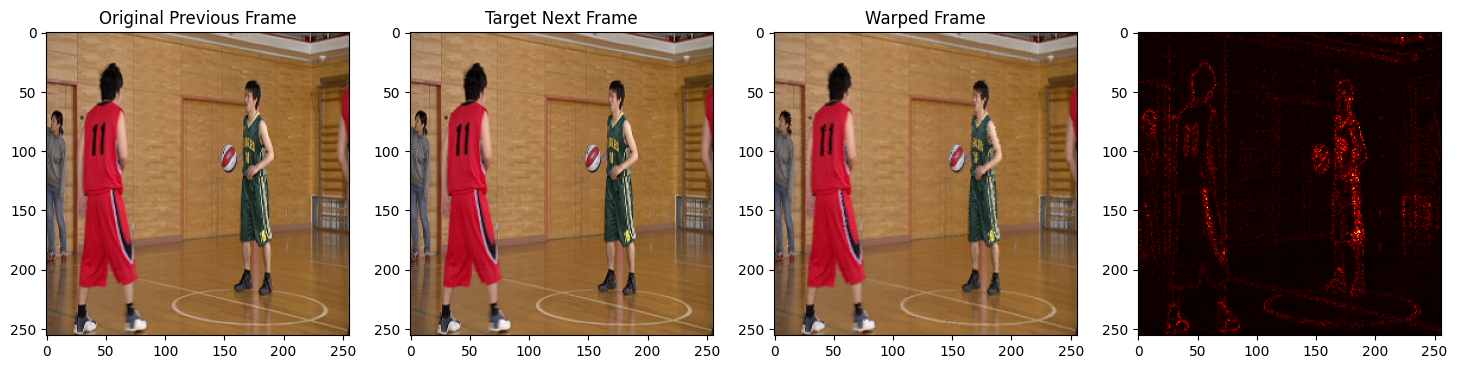

In [15]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import imageio

def warp_frame_with_motion_vectors(prev_frame_path, next_frame_path, autoencoder, motion_estimator, show_results=True):
    """
    Warps the previous frame using motion vectors estimated and compressed by the autoencoder.
    
    Args:
        prev_frame_path: Path to the previous frame (f001.png)
        next_frame_path: Path to the next frame (f002.png)
        autoencoder: Trained MotionAutoencoder instance
        motion_estimator: MotionEstimation instance
        show_results: Whether to display the visualization
    
    Returns:
        warped_frame: The warped frame using decoded motion vectors
        mse_error: Mean squared error between warped and target frame
    """
    # Load and preprocess frames
    def load_frame(filepath):
        frame = imageio.imread(filepath) / 255.0
        frame = ndimage.zoom(frame, (256/frame.shape[0], 256/frame.shape[1], 1))
        return tf.convert_to_tensor(frame[np.newaxis], dtype=tf.float32)
    
    prev_frame = load_frame(prev_frame_path)
    next_frame = load_frame(next_frame_path)
    
    # Estimate motion between frames
    flow, _ = motion_estimator.estimate_flow(prev_frame, next_frame)
    
    # Encode and decode the motion vectors
    decoded_flow, _ = autoencoder(flow)
    
    # Warp the previous frame using the decoded motion vectors
    warped_frame = tfa.image.dense_image_warp(prev_frame, decoded_flow)
    
    # Calculate error metrics
    mse_error = tf.reduce_mean(tf.square(warped_frame - next_frame))
    psnr = tf.image.psnr(warped_frame, next_frame, max_val=1.0)
    
    if show_results:
        # Visualize results
        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 4, 1)
        plt.imshow(prev_frame[0].numpy())
        plt.title("Original Previous Frame")
        
        plt.subplot(1, 4, 2)
        plt.imshow(next_frame[0].numpy())
        plt.title("Target Next Frame")
        
        plt.subplot(1, 4, 3)
        plt.imshow(warped_frame[0].numpy())
        plt.title("Warped Frame")
        
        plt.subplot(1, 4, 4)
        error = tf.abs(warped_frame - next_frame).numpy()[0]
        plt.imshow(error.mean(axis=-1), cmap='hot')
        plt.title(f"Absolute Error\nMSE: {mse_error:.4f}\nPSNR: {psnr:.2f} dB")
        plt.colorbar()
        
        plt.tight_layout()
        plt.show()
    
    return warped_frame, mse_error

# Example usage:
if __name__ == "__main__":
    # Initialize models (assuming these are already trained)
    motion_estimator = MotionEstimation(batch_size=1, height=256, width=256)
    autoencoder = MotionAutoencoder(height=256, width=256)
    
    # Paths to your frames
    prev_frame_path = r'C:\Users\anish\OneDrive\Desktop\pfe\research2\week4\data\f001.png'
    next_frame_path = r'C:\Users\anish\OneDrive\Desktop\pfe\research2\week4\data\f001.png'
    
    # Perform warping
    warped_frame, mse = warp_frame_with_motion_vectors(
        prev_frame_path,
        next_frame_path,
        autoencoder,
        motion_estimator
    )
    
    print(f"Warping completed with MSE: {mse:.6f}")

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_compression as tfc
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from scipy import ndimage
import imageio

# -------------------------------------------------------------------------------
# 1. Define the ResBlock and MC network using tf.keras layers.
# -------------------------------------------------------------------------------
def resblock(input_tensor, IC, OC, name):
    with tf.name_scope(name):
        l1 = tf.nn.relu(input_tensor, name=name + '_relu1')
        l1 = tf.keras.layers.Conv2D(
            filters=min(IC, OC),
            kernel_size=3,
            strides=1,
            padding='same',
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            name=name + '_l1'
        )(l1)
        l2 = tf.nn.relu(l1, name=name + '_relu2')
        l2 = tf.keras.layers.Conv2D(
            filters=OC,
            kernel_size=3,
            strides=1,
            padding='same',
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            name=name + '_l2'
        )(l2)
        if IC != OC:
            input_tensor = tf.keras.layers.Conv2D(
                filters=OC,
                kernel_size=1,
                strides=1,
                padding='same',
                kernel_initializer=tf.keras.initializers.GlorotUniform(),
                name=name + '_map'
            )(input_tensor)
        return input_tensor + l2

def MC_network(input_tensor):
    # m1
    m1 = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=1, padding='same',
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        name='mc1'
    )(input_tensor)
    # m2
    m2 = resblock(m1, 64, 64, name='mc2')
    # m3: average pooling
    m3 = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2, padding='same')(m2)
    # m4
    m4 = resblock(m3, 64, 64, name='mc4')
    # m5: average pooling
    m5 = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2, padding='same')(m4)
    # m6
    m6 = resblock(m5, 64, 64, name='mc6')
    # m7
    m7 = resblock(m6, 64, 64, name='mc7')
    # m8: upsample m7 by factor 2 and add m4
    m7_shape = tf.shape(m7)
    new_height = 2 * m7_shape[1]
    new_width = 2 * m7_shape[2]
    m8 = tf.image.resize(m7, size=[new_height, new_width], method='bilinear', name='resize_m8')
    m8 = tf.add(m4, m8, name='add_m8')
    # m9
    m9 = resblock(m8, 64, 64, name='mc9')
    # m10: upsample m9 by factor 2 and add m2
    m9_shape = tf.shape(m9)
    new_height = 2 * m9_shape[1]
    new_width = 2 * m9_shape[2]
    m10 = tf.image.resize(m9, size=[new_height, new_width], method='bilinear', name='resize_m10')
    m10 = tf.add(m2, m10, name='add_m10')
    # m11
    m11 = resblock(m10, 64, 64, name='mc11')
    # m12
    m12 = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=1, padding='same',
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        name='mc12'
    )(m11)
    m12 = tf.nn.relu(m12, name='relu12')
    # m13: final output layer (RGB image)
    m13 = tf.keras.layers.Conv2D(
        filters=3, kernel_size=3, strides=1, padding='same',
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        name='mc13'
    )(m12)
    return m13

def build_MC_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    outputs = MC_network(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MC_model')
    return model

# -------------------------------------------------------------------------------
# 2. Define the frame-warping function that uses a motion estimator and autoencoder.
# -------------------------------------------------------------------------------
def warp_frame_with_motion_vectors(prev_frame_path, next_frame_path, autoencoder, motion_estimator, show_results=True):
    """
    Loads two frames, estimates motion, decodes flow vectors, warps the previous frame,
    and computes error metrics.
    """
    def load_frame(filepath):
        frame = imageio.imread(filepath) / 255.0
        frame = ndimage.zoom(frame, (256 / frame.shape[0], 256 / frame.shape[1], 1))
        return tf.convert_to_tensor(frame[np.newaxis], dtype=tf.float32)
    
    prev_frame = load_frame(prev_frame_path)
    next_frame = load_frame(next_frame_path)
    
    # Estimate motion between frames
    flow, _ = motion_estimator.estimate_flow(prev_frame, next_frame)
    
    # Encode and decode the motion vectors (autoencoder should be pre-trained)
    decoded_flow, _ = autoencoder(flow)
    
    # Warp the previous frame using the decoded motion vectors
    warped_frame = tfa.image.dense_image_warp(prev_frame, decoded_flow)
    
    # Calculate error metrics
    mse_error = tf.reduce_mean(tf.square(warped_frame - next_frame))
    psnr = tf.image.psnr(warped_frame, next_frame, max_val=1.0)
    
    if show_results:
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(prev_frame[0].numpy())
        plt.title("Original Previous Frame")
        plt.subplot(1, 4, 2)
        plt.imshow(next_frame[0].numpy())
        plt.title("Target Next Frame")
        plt.subplot(1, 4, 3)
        plt.imshow(warped_frame[0].numpy())
        plt.title("Warped Frame")
        plt.subplot(1, 4, 4)
        error_img = tf.abs(warped_frame - next_frame).numpy()[0]
        plt.imshow(np.mean(error_img, axis=-1), cmap='hot')
        plt.title(f"Abs Error\nMSE: {mse_error:.4f}\nPSNR: {psnr:.2f} dB")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
    
    return warped_frame, mse_error

# -------------------------------------------------------------------------------
# 3. Dummy Models for Demonstration
#    (Replace these with your actual trained autoencoder and motion estimator.)
# -------------------------------------------------------------------------------
class DummyAutoencoder(tf.keras.Model):
    def call(self, inputs, training=False):
        # For demonstration, simply pass the flow through unchanged.
        return inputs, None

class DummyMotionEstimation:
    def __init__(self, batch_size, height, width):
        self.batch_size = batch_size
        self.height = height
        self.width = width
    def estimate_flow(self, im1, im2):
        # Returns a dummy flow (all zeros)
        flow = tf.zeros([self.batch_size, self.height, self.width, 2], dtype=tf.float32)
        return flow, None

# -------------------------------------------------------------------------------
# 4. Training Setup
# -------------------------------------------------------------------------------
# Image dimensions and batch size
batch_size = 1
img_height = 256
img_width = 256
input_shape = (img_height, img_width, 3)

# Build the MC model (our network from the MC function)
mc_model = build_MC_model(input_shape)
mc_model.summary()

# Instantiate dummy autoencoder and motion estimator.
autoencoder = DummyAutoencoder()
motion_estimator = DummyMotionEstimation(batch_size=batch_size, height=img_height, width=img_width)

# File paths for your frames (adjust these paths to your local files)
prev_frame_path = r'C:\Users\anish\OneDrive\Desktop\pfe\research2\week4\data\f001.png'
next_frame_path = r'C:\Users\anish\OneDrive\Desktop\pfe\research2\week4\data\f002.png'

# Use the warping function to create the warped frame (Y1_warp)
Y1_warp, _ = warp_frame_with_motion_vectors(prev_frame_path, next_frame_path, autoencoder, motion_estimator, show_results=True)

# The target frame (Y1_raw) is the actual next frame (f002.png)
target_frame = imageio.imread(next_frame_path) / 255.0
target_frame = ndimage.zoom(target_frame, (img_height / target_frame.shape[0], img_width / target_frame.shape[1], 1))
Y1_raw = tf.convert_to_tensor(target_frame[np.newaxis], dtype=tf.float32)

# Compile and train the MC model to refine the warped frame.
mc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
# For demonstration, we train on a single example (replace with your dataset in practice).
mc_model.fit(Y1_warp, Y1_raw, epochs=10)

# -------------------------------------------------------------------------------
# 5. After Training: Using the MC Model on Compressed Motion Vectors
